# PyopenCL kernel for 3D CLAHE

I implement a pyopencl kernel to process 3D images with **CLAHE** (Contrast Limited Adaptive Histogram Equalization) with GPU acceleration. I compare the performances of the CPU clahe algorithm (skimage.exposure.equalize_adapthist) and my GPU adapted one on 3D organoid microscopy images. I also compare the results to verify that CPU and GPU versions of clahe produce similar equalization. To visualize the results, upload an image to the 'Test_image' folder. To compare the results and performance over a large range of images, upload your 3D stacks into the 'Images' folder.

In [249]:
# import dependencies

import pyopencl as cl
import numpy as np
import os
import glob
import time
from skimage import io , exposure
import matplotlib.pyplot as plt

In [250]:
# specify main directory
main_dir = 'C:/Users/gerriadmin/Desktop/Morphology project Hugo/pyopencl_clahe/'

# specify subdirectories
test_dir = main_dir + 'Test_image/'
img_dir = main_dir + 'Images/'

## GPU implementation
For GPU implementation of CLAHE, we use a custom pyopenCL kernel (cf .py file in the main directory), in which we parallelize the code for clahe. Importantly, we transform the 3D image structure into a flattened array. 

In [251]:
# run the GPU clahe kernel 'clahe_3D_kernel.py'
os.chdir(main_dir)
%run clahe_3D_kernel.py

# Setup OpenCL environment (You might have to modify the platform and devices to use with GPU)
platform = cl.get_platforms()[1]
device = platform.get_devices()[0]
context = cl.Context([device])
queue = cl.CommandQueue(context)
program = cl.Program(context, clahe_3D_kernel).build()


mf = cl.mem_flags

print('Device:', device)

Device: <pyopencl.Device 'NVIDIA RTX A6000' on 'NVIDIA CUDA' at 0x1affc1b49e0>


In [252]:
# function to normalize imported images and convert to 8bit:
def norm8bit(raw_image):
    imin , imax = np.min(raw_image), np.max(raw_image)
    norm = 255 / (imax - imin) * (raw_image - imin)
    return np.array(norm).astype('uint8')

In [253]:
# Define CLAHE parameters
tile_size = 8
clip_limit = 0.01*255# top 1% of the histogram for an 8-bit image


def clahe_gpu(image):
    raw_image = io.imread(image) # open image as 3D array
    norm_img = norm8bit(raw_image) # normalize
    
    depth, height, width = norm_img.shape # get image dimensions
    min_intensity = np.min(norm_img) # should be 0
    max_intensity = np.max(norm_img) # should be 255

    
    # Create OpenCL buffers
    img_buf = cl.Buffer(context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=norm_img)
    result_buf = cl.Buffer(context, mf.WRITE_ONLY, norm_img.nbytes)

    #initiate computation time
    t0 = time.time()

    # Execute the kernel
    global_size = (width, height, depth)
    program.clahe_3D(queue, global_size, None, img_buf, result_buf, 
                      np.int32(width), np.int32(height), np.int32(depth), np.int32(tile_size),
                      np.float32(clip_limit), np.float32(min_intensity), np.float32(max_intensity))
        
    # Retrieve the result
    result_np = np.empty_like(norm_img)
    cl.enqueue_copy(queue, result_np, result_buf).wait()

    print('Computation time with GPU:', time.time()-t0)
    return result_np , time.time()-t0

Let's test the algorithm on a few images, here a 3D stack of an organoid stained with DAPI and E-Cadherin.

Computation time with GPU: 0.75486159324646
Computation time with GPU: 0.7879323959350586


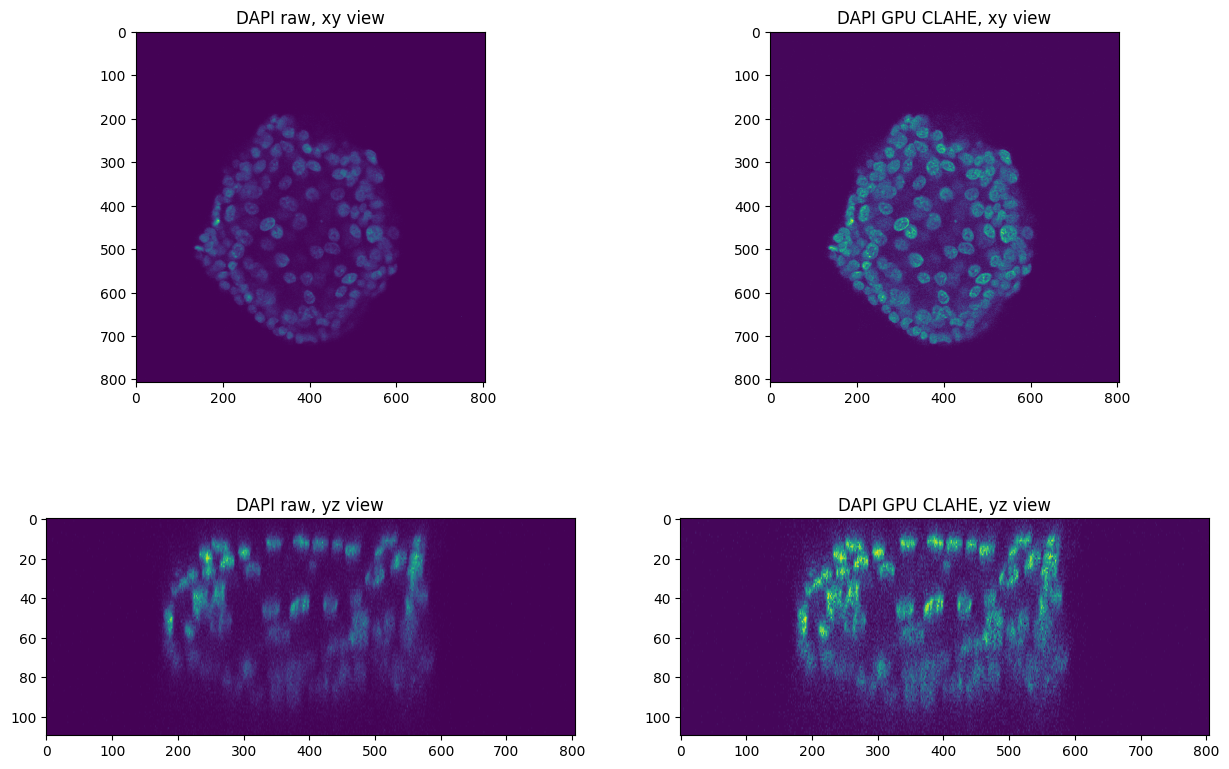

In [254]:
# get images
os.chdir(test_dir)
images = sorted(glob.glob('*.tif'))
image = images[:]

raw = []
results_gpu = []
time_gpu  = []

for image in images:
    raw.append(norm8bit(io.imread(image)))
    results , t = clahe_gpu(image)
    results_gpu.append(results)
    time_gpu.append(t)

halfz = int(np.shape(raw[0])[0]/2)
halfx = int(np.shape(raw[0])[1]/2)

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0][0].imshow(raw[0][halfz])
axs[0][1].imshow(results_gpu[0][halfz])
axs[1][0].imshow(raw[0][:,halfx,:], aspect = 3)
axs[1][1].imshow(results_gpu[0][:,halfx,:], aspect = 3)
axs[0][0].set_title('DAPI raw, xy view')
axs[0][1].set_title('DAPI GPU CLAHE, xy view')
axs[1][0].set_title('DAPI raw, yz view')
axs[1][1].set_title('DAPI GPU CLAHE, yz view')
plt.show()

## CPU implementation

In [255]:
def clahe_cpu(image):
    raw_image = io.imread(image)
    
    t0 = time.time()
    equalized = exposure.equalize_adapthist(raw_image, kernel_size=8, clip_limit=0.01, nbins=256)
    print('Computation time with CPU:', time.time()-t0)
    
    return norm8bit(equalized) , time.time()-t0

Let's look at the results

Computation time with CPU: 14.136048555374146
Computation time with CPU: 14.172771692276001


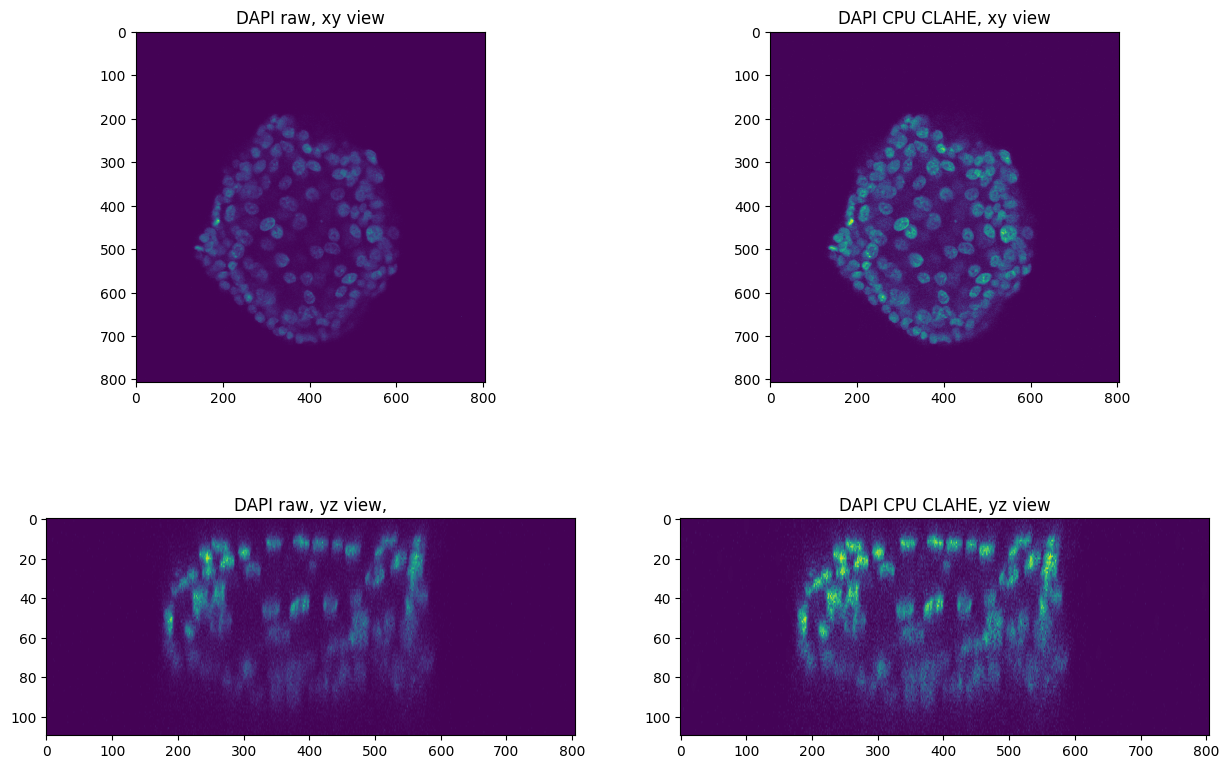

In [256]:
# get images
os.chdir(test_dir)
images = sorted(glob.glob('*.tif'))
image = images[:]

raw = []
results_cpu = []
time_cpu  = []

for image in images:
    base = os.path.splitext(image)[0]
    raw.append(norm8bit(io.imread(image)))
    results , t = clahe_cpu(image)
    results_cpu.append(results)
    time_cpu.append(t)

halfz = int(np.shape(raw[0])[0]/2)
halfx = int(np.shape(raw[0])[1]/2)

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0][0].imshow(raw[0][halfz])
axs[0][1].imshow(results_cpu[0][halfz])
axs[1][0].imshow(raw[0][:,halfx,:], aspect = 3)
axs[1][1].imshow(results_cpu[0][:,halfx,:], aspect = 3)
axs[0][0].set_title('DAPI raw, xy view')
axs[0][1].set_title('DAPI CPU CLAHE, xy view')
axs[1][0].set_title('DAPI raw, yz view,')
axs[1][1].set_title('DAPI CPU CLAHE, yz view')
plt.show()

## Comparing the results of CLAHE GPU and skimage exposure.equalize_adapthist

Text(0.5, 1.0, 'ECad, CLAHE CPU')

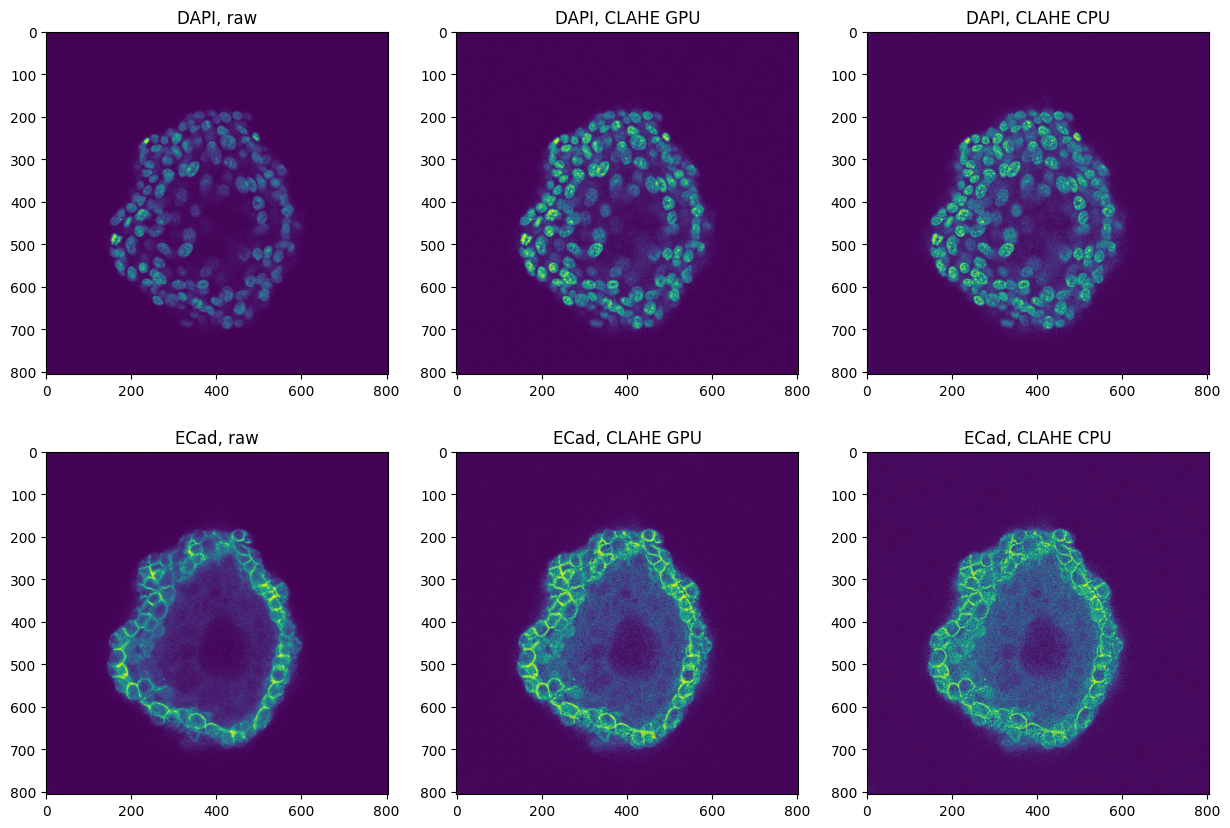

In [257]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
axs[0][0].imshow(raw[0][30])
axs[0][1].imshow(results_cpu[0][30])
axs[0][2].imshow(results_gpu[0][30])
axs[1][0].imshow(raw[1][30])
axs[1][1].imshow(results_cpu[1][30])
axs[1][2].imshow(results_gpu[1][30])
axs[0][0].set_title('DAPI, raw')
axs[0][1].set_title('DAPI, CLAHE GPU')
axs[0][2].set_title('DAPI, CLAHE CPU')
axs[1][0].set_title('ECad, raw')
axs[1][1].set_title('ECad, CLAHE GPU')
axs[1][2].set_title('ECad, CLAHE CPU')

Let's compare the histograms of the different images

In [261]:
# get images
os.chdir(img_dir)
images = sorted(glob.glob('*.tif'))
image = images[:]

# find image size and computation time
raw = []
image_size = []
results_cpu = []
time_cpu  = []
results_gpu = []
time_gpu  = []

for image in images:
    base = os.path.splitext(image)[0]
    raw_image = norm8bit(io.imread(image))
    size = raw_image.size
    print(base, ' Image size=', size/10**6, 'MB')
    raw.append(raw_image)
    image_size.append(size)
    
    rc , tc = clahe_cpu(image)
    results_cpu.append(rc)
    time_cpu.append(tc)
    
    rg , tg = clahe_gpu(image)
    results_gpu.append(rg)
    time_gpu.append(tg)

TOrg1 DAPI  Image size= 60.042375 MB
Computation time with CPU: 11.851274013519287
Computation time with GPU: 0.8821067810058594
TOrg2 DAPI  Image size= 71.28264 MB
Computation time with CPU: 14.08876657485962
Computation time with GPU: 0.9297332763671875
TOrg2 ECad  Image size= 71.28264 MB
Computation time with CPU: 14.177794933319092
Computation time with GPU: 1.0883526802062988
TOrg3 DAPI  Image size= 24.115572 MB
Computation time with CPU: 4.7984864711761475
Computation time with GPU: 0.42951464653015137
TOrg3 ECad  Image size= 24.115572 MB
Computation time with CPU: 4.828730821609497
Computation time with GPU: 0.5324885845184326
TOrg4 DAPI  Image size= 64.562736 MB
Computation time with CPU: 12.786809921264648
Computation time with GPU: 1.0235960483551025
TOrg4 ECad  Image size= 64.562736 MB
Computation time with CPU: 12.737353086471558
Computation time with GPU: 1.0886023044586182


In [258]:
vals_raw , vals_gpu , vals_cpu = [] , [] , []

for i in range(len(raw)):
    vals_raw.append(np.histogram(raw[i], bins = 50)[0])
    vals_cpu.append(np.histogram(results_cpu[i], bins = 50)[0])
    vals_gpu.append(np.histogram(results_gpu[i], bins = 50)[0])
    

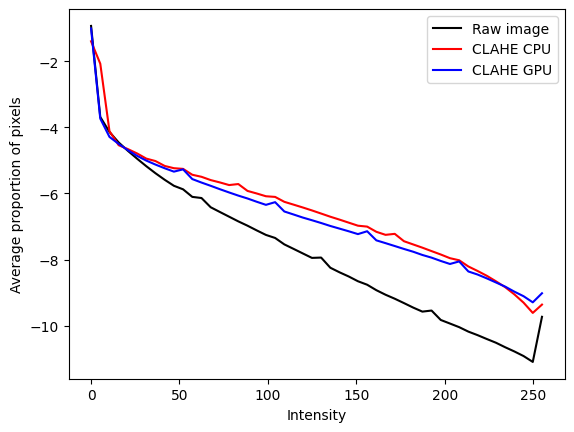

In [259]:
bins = np.linspace(0,255,50)

avg_raw , avg_cpu , avg_gpu = [np.mean(x) for x in np.transpose(vals_raw/np.sum(vals_raw))] , [np.mean(x) for x in np.transpose(vals_cpu/np.sum(vals_cpu))] , [np.mean(x) for x in np.transpose(vals_gpu/np.sum(vals_gpu))]


plt.plot(bins, np.log(avg_raw),color='k',label='Raw image')
plt.plot(bins, np.log(avg_gpu), color='r',label='CLAHE CPU')
plt.plot(bins, np.log(avg_cpu), color='b',label='CLAHE GPU')
plt.xlabel('Intensity')
plt.ylabel('Average proportion of pixels')
plt.legend()
plt.show()

Normally the distributions for GPU and CPU processed CLAHE should be similar and enrched in higher intensity values.

## Performance comparison

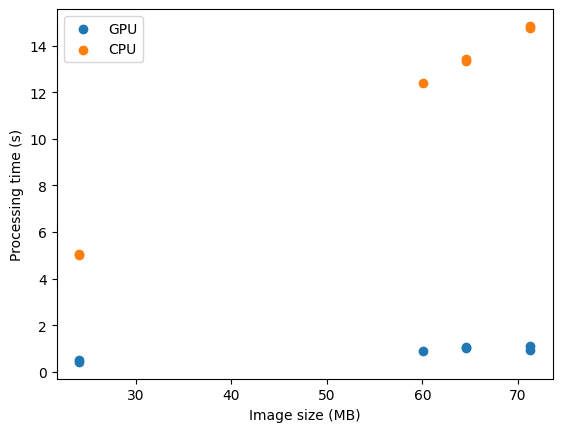

In [268]:
plt.scatter(np.array(image_size)/10**6,time_gpu,label='GPU')
plt.scatter(np.array(image_size)/10**6,time_cpu,label='CPU')
plt.xlabel('Image size (MB)')
plt.ylabel('Processing time (s)')
plt.legend()
plt.show()